# Duck Example

In [1]:
import pandas as pd
from pymeos import *
import matplotlib.pyplot as plt

pymeos_initialize()

In [16]:
df = pd.read_csv("../datasets/geese.csv")
df.head()

,Timestamp,AnimalID,Latitude,Longitude,Altitude (m)
0,2024-06-01 08:00:00,A1,52.3761,4.9089,15
1,2024-06-01 08:00:00,A2,52.3700,4.9070,12
2,2024-06-01 08:00:00,A3,52.3650,4.9050,10
3,2024-06-01 08:05:00,A1,52.3780,4.9095,20
4,2024-06-01 08:05:00,A2,52.3720,4.9075,15


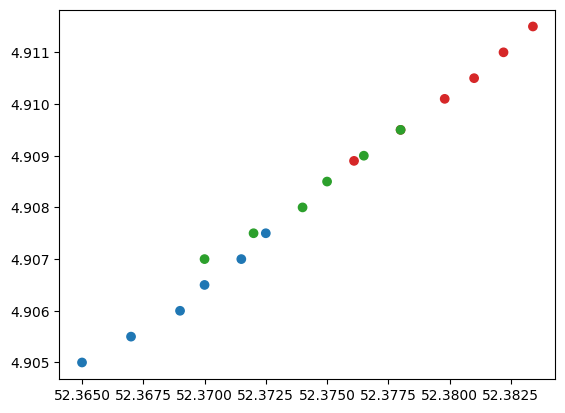

In [3]:
color = {"A1": "tab:red", "A2": "tab:green", "A3": "tab:blue"}
df["color"] = df["AnimalID"].map(color)
plt.scatter(x = df["Latitude"], y=df["Longitude"], c=df['color'])

In [32]:
from shapely import Point
pymeos_initialize("UTC")
df['TPointInst'] = df.apply(lambda x: TGeomPointInst(point=Point(x['Latitude'], x['Longitude']), timestamp=x['Timestamp']), axis=1)
df['TAltitudeInst'] = df.apply(lambda x: TIntInst(value=x['Altitude (m)'], timestamp=x['Timestamp']), axis=1)

,Timestamp,AnimalID,Latitude,Longitude,Altitude (m),TPointInst,TAltitudeInst
0,2024-06-01 08:00:00,A1,52.3761,4.9089,15,POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,15@2024-06-01 08:00:00+00
1,2024-06-01 08:00:00,A2,52.3700,4.9070,12,POINT(52.37 4.907)@2024-06-01 08:00:00+00,12@2024-06-01 08:00:00+00
2,2024-06-01 08:00:00,A3,52.3650,4.9050,10,POINT(52.365 4.905)@2024-06-01 08:00:00+00,10@2024-06-01 08:00:00+00
3,2024-06-01 08:05:00,A1,52.3780,4.9095,20,POINT(52.378 4.9095)@2024-06-01 08:05:00+00,20@2024-06-01 08:05:00+00
4,2024-06-01 08:05:00,A2,52.3720,4.9075,15,POINT(52.372 4.9075)@2024-06-01 08:05:00+00,15@2024-06-01 08:05:00+00


In [66]:
pymeos_initialize("UTC")
# Group by AnimalID and collect the values of each row into a single column
traj_df = df.groupby('AnimalID').apply(
    lambda x: pd.Series({
        'TPointSeq': TGeomPointSeq(instant_list=x['TPointInst']),
        'TAltitudeSeq': TIntSeq(instant_list=x['TAltitudeInst'], interpolation=TInterpolation.DISCRETE)
    })
).reset_index()

#traj_df.columns = ['AnimalID', 'TPointSeq']


# Display the resulting DataFrame
traj_df

/tmp/ipykernel_6600/143059556.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  traj_df = df.groupby('AnimalID').apply(


,AnimalID,TPointSeq,TAltitudeSeq
0,A1,"[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,...","{15@2024-06-01 08:00:00+00, 20@2024-06-01 08:0..."
1,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0..."
2,A3,"[POINT(52.365 4.905)@2024-06-01 08:00:00+00, P...","{10@2024-06-01 08:00:00+00, 14@2024-06-01 08:0..."


In [67]:
bounds = TemporalPointExtentAggregator().aggregate(list(traj_df['TPointSeq']))
bounds

STBox(STBOX XT(((52.365,4.905),(52.3834,4.9115)),[2024-06-01 08:00:00+00, 2024-06-01 08:25:00+00)))

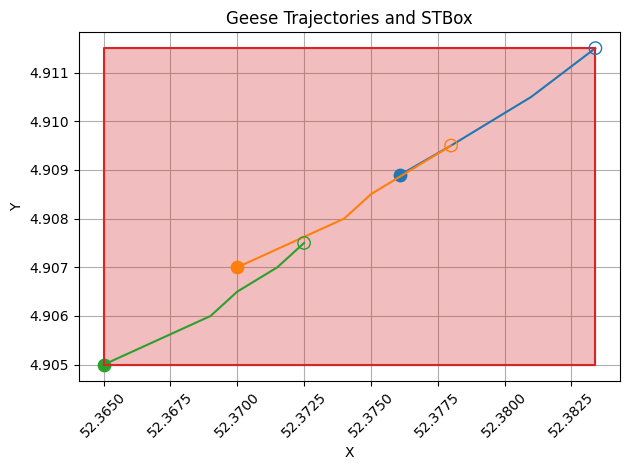

In [245]:
for i, row in traj_df.iterrows():
    row['TPointSeq'].plot()
bounds.plot_xy()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Geese Trajectories and STBox')
plt.tight_layout()
plt.savefig("../sample_charts/geese_trajs.png")
plt.show()

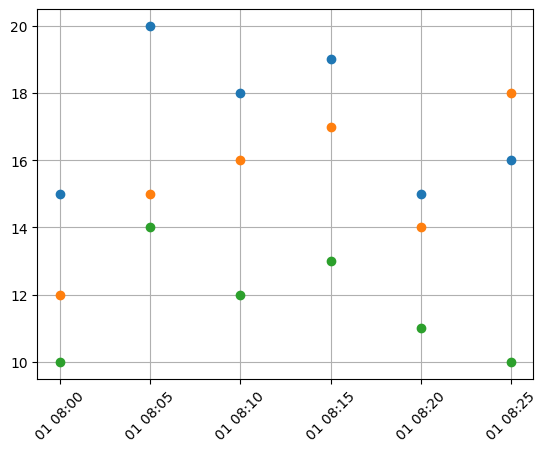

In [69]:
for i, row in traj_df.iterrows():
    row['TAltitudeSeq'].plot()

In [212]:
from shapely import from_wkt, plotting
nests = pd.read_csv("../datasets/nests.csv")
nests['Geometry'] = nests['Geometry'].apply(from_wkt)
nests['NestID'] = nests['NestID'].astype(str)
nests

,NestID,Geometry
0,Nest1,"POLYGON ((52.36685528425732 4.907179714281839,..."
1,Nest2,POLYGON ((52.378520846545285 4.908661844965728...
2,Nest3,"POLYGON ((52.37626124526781 4.908543787414512,..."


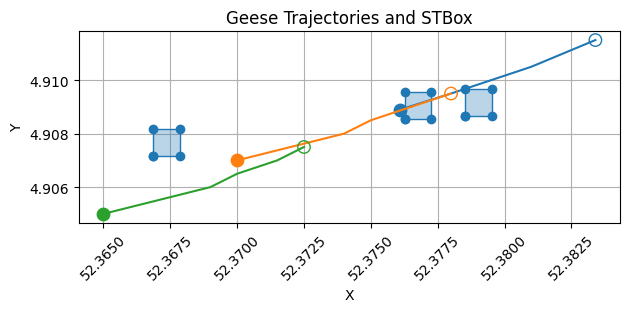

In [246]:
for i, row in traj_df.iterrows():
    row['TPointSeq'].plot()
#bounds.plot_xy()

for i, row in nests.iterrows():
    plotting.plot_polygon(row['Geometry'])

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Geese Trajectories and STBox')
plt.tight_layout()
plt.savefig("../sample_charts/geese_trajs_nests.png")
plt.show()

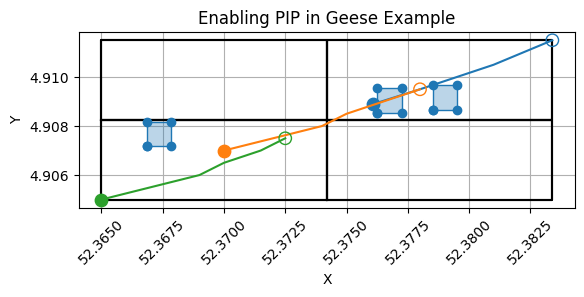

In [214]:
from pysparkmeos.partitions.grid_partitioner import GridPartition
grid = GridPartition(cells_per_side=2, bounds=bounds)

grid.plot(draw_filling=False, color='black')

for i, row in traj_df.iterrows():
    row['TPointSeq'].plot()
#bounds.plot_xy()

for i, row in nests.iterrows():
    plotting.plot_polygon(row['Geometry'])



plt.xlabel('X')
plt.ylabel('Y')
plt.title('Enabling PIP in Geese Example')

plt.savefig("../sample_charts/pip_geese_trajs_nests.png")
plt.show()

In [220]:
griddf = pd.DataFrame(grid.grid, columns=['tile'])
griddf['tileid'] = griddf.index.astype(int)
griddf

,tile,tileid
0,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0
1,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",1
2,"STBOX XT(((52.365,4.908250000000001),(52.3742,...",2
3,"STBOX XT(((52.365,4.908250000000001),(52.3742,...",3
4,"STBOX XT(((52.3742,4.905),(52.3834,4.908250000...",4
5,"STBOX XT(((52.3742,4.905),(52.3834,4.908250000...",5
6,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6
7,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",7


In [223]:
nests_tiled = griddf.join(nests, how='cross').where(griddf.join(nests, how='cross').apply(lambda x: x['tile'].contains(x['Geometry']), axis=1)).dropna()
#nests_tiled.drop(columns=['tile'], inplace=True)
#nests_tiled['tileid'] = nests_tiled['tileid'].astype(int)
nests_tiled

,tile,tileid,NestID,Geometry
0,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0.0,Nest1,"POLYGON ((52.36685528425732 4.907179714281839,..."
3,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",1.0,Nest1,"POLYGON ((52.36685528425732 4.907179714281839,..."
19,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,Nest2,POLYGON ((52.378520846545285 4.908661844965728...
20,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,Nest3,"POLYGON ((52.37626124526781 4.908543787414512,..."
22,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",7.0,Nest2,POLYGON ((52.378520846545285 4.908661844965728...
23,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",7.0,Nest3,"POLYGON ((52.37626124526781 4.908543787414512,..."


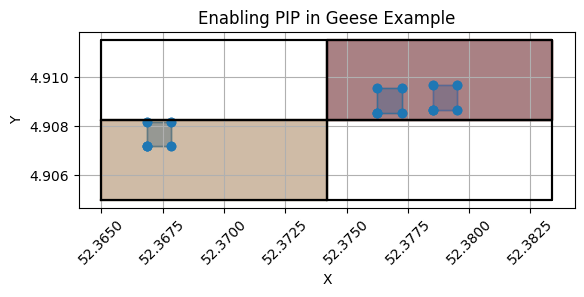

In [224]:
for i, row in nests_tiled.iterrows():
    #row['TPointAt'].plot()
    plotting.plot_polygon(row['Geometry'])#bounds.plot_xy()
    row['tile'].plot_xy()

grid.plot(draw_filling=False, color='black')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Enabling PIP in Geese Example')

plt.show()

In [225]:
trajs_tiled = griddf.join(traj_df, how='cross').where(griddf.join(traj_df, how='cross').apply(lambda x: x['TPointSeq'].ever_intersects(x['tile']), axis=1)).dropna()
trajs_tiled['TPointAt'] = trajs_tiled.apply(lambda x: x['TPointSeq'].at(x['tile']), axis=1)
#trajs_tiled.drop(columns=['TPointSeq'], inplace=True)
trajs_tiled.dropna(inplace=True)
trajs_tiled

,tile,tileid,AnimalID,TPointSeq,TAltitudeSeq,TPointAt
1,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...","{[POINT(52.37 4.907)@2024-06-01 08:00:00+00, P..."
2,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0.0,A3,"[POINT(52.365 4.905)@2024-06-01 08:00:00+00, P...","{10@2024-06-01 08:00:00+00, 14@2024-06-01 08:0...","{[POINT(52.365 4.905)@2024-06-01 08:00:00+00, ..."
5,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",1.0,A3,"[POINT(52.365 4.905)@2024-06-01 08:00:00+00, P...","{10@2024-06-01 08:00:00+00, 14@2024-06-01 08:0...",{[POINT(52.3695 4.90625)@2024-06-01 08:12:30+0...
13,"STBOX XT(((52.3742,4.905),(52.3834,4.908250000...",4.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...",{[POINT(52.3742 4.9081)@2024-06-01 08:11:00+00...
16,"STBOX XT(((52.3742,4.905),(52.3834,4.908250000...",5.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...",{[POINT(52.3745 4.908250000000001)@2024-06-01 ...
18,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,A1,"[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,...","{15@2024-06-01 08:00:00+00, 20@2024-06-01 08:0...",{[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00...
19,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...",{[POINT(52.3745 4.908250000000001)@2024-06-01 ...
21,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",7.0,A1,"[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,...","{15@2024-06-01 08:00:00+00, 20@2024-06-01 08:0...",{[POINT(52.3804 4.910299999999999)@2024-06-01 ...
22,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",7.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...",{[POINT(52.3745 4.908250000000001)@2024-06-01 ...


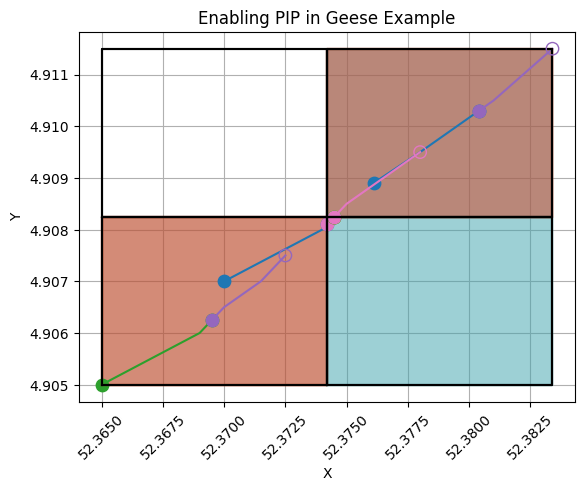

In [226]:
for i, row in trajs_tiled.iterrows():
    row['TPointAt'].plot()
    #plotting.plot_polygon(row['Geometry'])#bounds.plot_xy()
    row['tile'].plot_xy()
    
grid.plot(draw_filling=False, color='black')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Enabling PIP in Geese Example')

plt.show()

In [235]:
intersect = trajs_tiled.merge(nests_tiled, on='tileid', how='inner')
intersect = intersect[intersect.index.notnull()]
intersect['tile'] = intersect['tile_x']
intersect.head()

,tile_x,tileid,AnimalID,TPointSeq,TAltitudeSeq,TPointAt,tile_y,NestID,Geometry,tile
0,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0.0,A2,"[POINT(52.37 4.907)@2024-06-01 08:00:00+00, PO...","{12@2024-06-01 08:00:00+00, 15@2024-06-01 08:0...","{[POINT(52.37 4.907)@2024-06-01 08:00:00+00, P...","STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",Nest1,"POLYGON ((52.36685528425732 4.907179714281839,...","STBOX XT(((52.365,4.905),(52.3742,4.9082500000..."
1,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",0.0,A3,"[POINT(52.365 4.905)@2024-06-01 08:00:00+00, P...","{10@2024-06-01 08:00:00+00, 14@2024-06-01 08:0...","{[POINT(52.365 4.905)@2024-06-01 08:00:00+00, ...","STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",Nest1,"POLYGON ((52.36685528425732 4.907179714281839,...","STBOX XT(((52.365,4.905),(52.3742,4.9082500000..."
2,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",1.0,A3,"[POINT(52.365 4.905)@2024-06-01 08:00:00+00, P...","{10@2024-06-01 08:00:00+00, 14@2024-06-01 08:0...",{[POINT(52.3695 4.90625)@2024-06-01 08:12:30+0...,"STBOX XT(((52.365,4.905),(52.3742,4.9082500000...",Nest1,"POLYGON ((52.36685528425732 4.907179714281839,...","STBOX XT(((52.365,4.905),(52.3742,4.9082500000..."
3,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,A1,"[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,...","{15@2024-06-01 08:00:00+00, 20@2024-06-01 08:0...",{[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00...,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",Nest2,POLYGON ((52.378520846545285 4.908661844965728...,"STBOX XT(((52.3742,4.908250000000001),(52.3834..."
4,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",6.0,A1,"[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00,...","{15@2024-06-01 08:00:00+00, 20@2024-06-01 08:0...",{[POINT(52.3761 4.9089)@2024-06-01 08:00:00+00...,"STBOX XT(((52.3742,4.908250000000001),(52.3834...",Nest3,"POLYGON ((52.37626124526781 4.908543787414512,...","STBOX XT(((52.3742,4.908250000000001),(52.3834..."


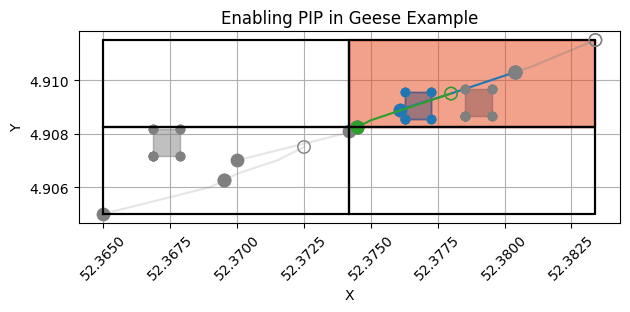

In [247]:
for i, row in intersect.iterrows():
    if row['TPointAt'].ever_intersects(row['Geometry']):
        row['TPointAt'].plot()
        plotting.plot_polygon(row['Geometry'])#bounds.plot_xy()
        row['tile'].plot_xy()
    else:
        row['TPointAt'].plot(color='grey', alpha=0.2)
        plotting.plot_polygon(row['Geometry'], color='grey', alpha=0.2)#bounds.plot_xy()
        #row['tile'].plot_xy(color='grey')

grid.plot(draw_filling=False, color='black')



plt.xlabel('X')
plt.ylabel('Y')
plt.title('Enabling PIP in Geese Example')
plt.tight_layout()
plt.savefig("../sample_charts/pip_geese_trajs_nests_final.png")
plt.show()